In [481]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
#import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

In [482]:
import numpy as np
import scipy.misc
from scipy import ndimage
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [555]:
#ff = glob.glob('../SampleXrayImages/80177/view1/*.jpg')
ff = glob.glob('/data/user/wsmonroe/Endodontics/jRosario/data/*.tif')
ff[0]
#ffTest = glob.glob('../SampleXrayImages/80177/view1/anomaly/*')
ffTest = glob.glob('/data/user/wsmonroe/Endodontics/jRosario/Group C/*.tif')

In [556]:
len(ff)

224

In [557]:
images = []
imagesTest = []

In [558]:
for f in range(len(ff)):
    #print(ff[f])
    a = Image.open(ff[f]).convert('LA')
    a = a.crop((0,0,900,900))
    a = np.array(a)
    #a = ndimage.median_filter(a, 5)
    #a.astype(int)
    a = resize(a, (128, 128),
                       anti_aliasing=True)
    a = ndimage.median_filter(a, 3)
    a = ndimage.gaussian_filter(a,0.5)
    #a = a[:,:]
    #for i in range(a.shape[1]):
    images.append(a[:,:,0])
print (a.shape)

/home/wsmonroe/.conda/envs/distributedLearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(128, 128, 2)


In [559]:
for f in range(len(ffTest)):
    #print(ff[f])
    a = Image.open(ffTest[f]).convert('LA')
    a = a.crop((0,0,800,800))
    a = np.array(a)
    a = resize(a, (128, 128),
                       anti_aliasing=True)
    
    #a = a[:,:]
    #for i in range(a.shape[1]):
    imagesTest.append(a[:,:,0])
print (a.shape)

/home/wsmonroe/.conda/envs/distributedLearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(128, 128, 2)


In [560]:
images = np.array(images)
imagesTest = np.array(imagesTest)

In [561]:
images.shape

(224, 128, 128)

In [562]:
images = images.reshape(-1, 128,128,1)
imagesTest = imagesTest.reshape(-1, 128,128,1)


In [563]:
images.shape

(224, 128, 128, 1)

In [564]:
m = np.max(images)
mi = np.min(images)

In [565]:
m, mi

(1.0, 0.08425559084339428)

In [566]:
images = (images - mi) / (m - mi)

In [567]:
np.min(images), np.max(images)

(0.0, 1.0)

In [568]:
m = np.max(imagesTest)
mi = np.min(imagesTest)
imagesTest = (imagesTest - mi) / (m - mi)

In [569]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images,
                                                             test_size=0.2,
                                                             random_state=13)

In [570]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images.shape))


Dataset (images) shape: (224, 128, 128, 1)


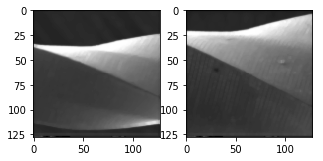

In [571]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (128,128))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[0], (128,128))
plt.imshow(curr_img, cmap='gray')

In [500]:
batch_size = 8
epochs = 200
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

In [501]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [502]:
autoencoderModel = Model(input_img, autoencoder(input_img))
autoencoderModel.compile(loss='mean_squared_error', optimizer = RMSprop())

In [503]:
autoencoderModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_151 (Bat (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_152 (Bat (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 64, 64, 64)        18496     
__________

In [504]:
autoencoder_train = autoencoderModel.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 179 samples, validate on 45 samples
Epoch 1/200
179/179 [==============================] - 4s 22ms/step - loss: 0.0223 - val_loss: 0.0171
Epoch 2/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0978
Epoch 3/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0196
Epoch 4/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0128
Epoch 5/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0166
Epoch 6/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0206
Epoch 7/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0257
Epoch 8/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0250
Epoch 9/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0189
Epoch 10/200
179/179 [=======================

179/179 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 81/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 82/200
179/179 [==============================] - 0s 2ms/step - loss: 8.9167e-04 - val_loss: 6.4379e-04
Epoch 83/200
179/179 [==============================] - 0s 2ms/step - loss: 7.3654e-04 - val_loss: 0.0023
Epoch 84/200
179/179 [==============================] - 0s 2ms/step - loss: 8.8064e-04 - val_loss: 0.0019
Epoch 85/200
179/179 [==============================] - 0s 2ms/step - loss: 7.5252e-04 - val_loss: 4.5102e-04
Epoch 86/200
179/179 [==============================] - 0s 2ms/step - loss: 9.5326e-04 - val_loss: 0.0014
Epoch 87/200
179/179 [==============================] - 0s 2ms/step - loss: 9.2675e-04 - val_loss: 4.6674e-04
Epoch 88/200
179/179 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 89/200
179/179 [==============================] - 0s 

179/179 [==============================] - 0s 2ms/step - loss: 7.0537e-04 - val_loss: 5.5933e-04
Epoch 157/200
179/179 [==============================] - 0s 2ms/step - loss: 5.1536e-04 - val_loss: 9.0966e-04
Epoch 158/200
179/179 [==============================] - 0s 2ms/step - loss: 5.7683e-04 - val_loss: 0.0013
Epoch 159/200
179/179 [==============================] - 0s 2ms/step - loss: 5.4187e-04 - val_loss: 4.3409e-04
Epoch 160/200
179/179 [==============================] - 0s 2ms/step - loss: 5.8593e-04 - val_loss: 7.3377e-04
Epoch 161/200
179/179 [==============================] - 0s 2ms/step - loss: 5.9074e-04 - val_loss: 2.6691e-04
Epoch 162/200
179/179 [==============================] - 0s 2ms/step - loss: 7.1180e-04 - val_loss: 7.9330e-04
Epoch 163/200
179/179 [==============================] - 0s 2ms/step - loss: 6.9656e-04 - val_loss: 2.8877e-04
Epoch 164/200
179/179 [==============================] - 0s 2ms/step - loss: 6.1528e-04 - val_loss: 9.6056e-04
Epoch 165/200
179/1

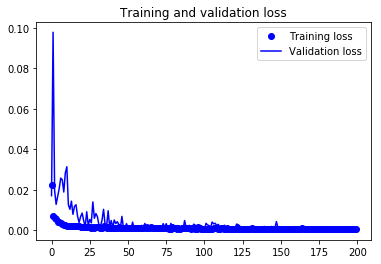

In [505]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [506]:
autoencoderOut = autoencoderModel.save_weights('autoencoder_sem.h5')

In [507]:
autoencoderRebuild = Model(input_img, autoencoder(input_img))


In [508]:
autoencoderRebuild.load_weights('autoencoder_sem.h5')

In [572]:
pred = autoencoderRebuild.predict(imagesTest)
predN = autoencoderRebuild.predict(images)

Test Images


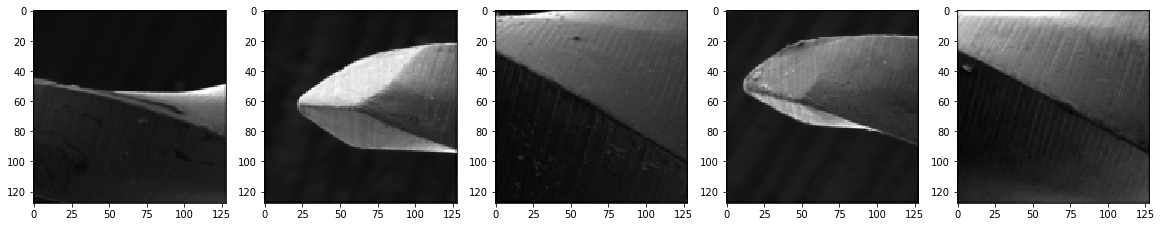

Reconstruction of Test Images


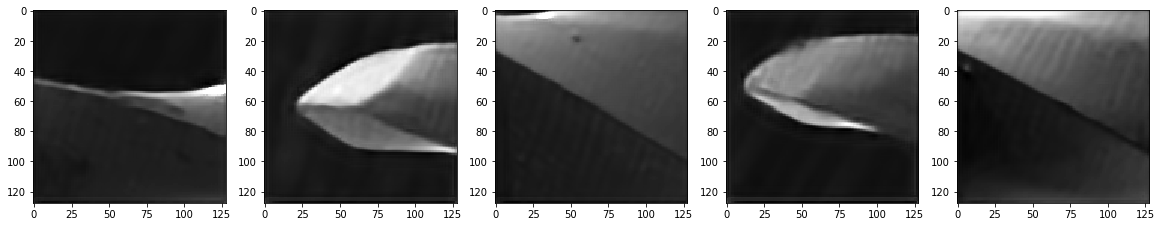

Difference of Anomaly Images
8.192359109431013
6.271189441496966
6.028570612866967
6.133952769880326
6.21495584990181


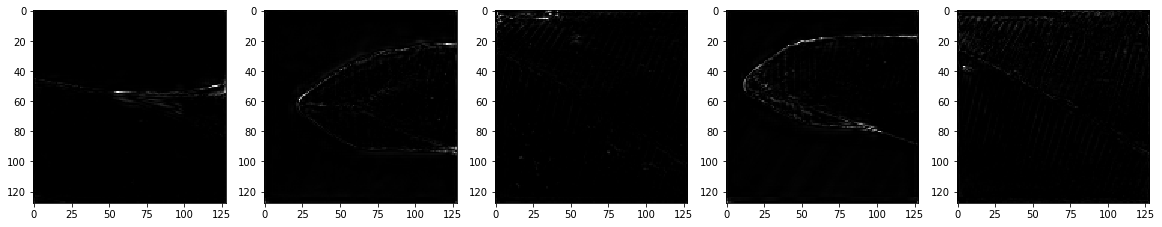

Difference of Regular Images
6.791368862861625
2.624010856566005
4.3429969703062365
4.546072708887728
3.179122426271308


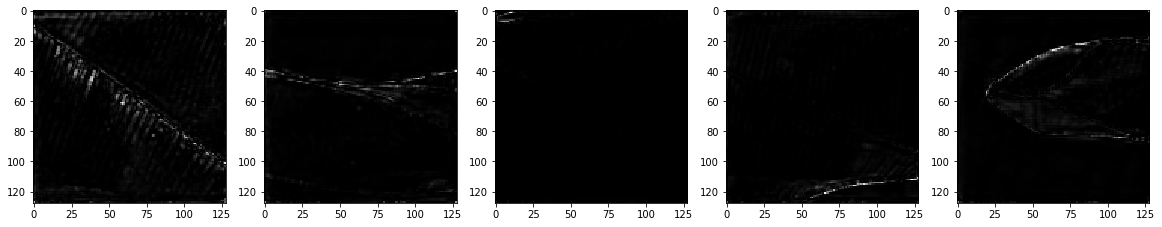

In [573]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(imagesTest[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()
plt.figure(figsize=(20, 4))
print("Difference of Anomaly Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2), cmap='gray') 
    print(sum(sum((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2))))
plt.show()
plt.figure(figsize=(20, 4))
print("Difference of Regular Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow((np.array(predN[i, ..., 0]-images[i,...,0])**2), cmap='gray') 
    print(sum(sum((np.array(predN[i, ..., 0]-images[i,...,0])**2))))
plt.show()

In [574]:
for i in range(imagesTest.shape[0]):
    #print(sum(sum((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2))))
    #plt.imshow((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2), cmap='gray') 
    print(sum(sum((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2))))
    #plt.show()
   # ((A-B)**2).sum()

8.192359109431013
6.271189441496966
6.028570612866967
6.133952769880326
6.21495584990181
18.13451174778627
8.334300736830203
3.4320113891493573
12.767317364967184
7.584705586585264
11.418523148369605
6.246982695541099
6.466700158441178
5.866622099610768
7.188433222181716
8.84021075338601
9.778671931030336
7.40511906899019
9.889384658100322
7.891782954315984
3.612704645963512
13.718541470631132
28.680363857671704
3.8993709995616954
7.495781936144078
7.6616385741792925
15.10462449875782
9.724554654755975
15.801418049323397
8.14557765170764
4.33758071559432
28.228103497502914
6.60979314515273
3.9991985368807867
14.94530284715385
18.314060182442734
6.830117451593394
5.576231204277948
3.103909694158144
10.806051549225947
6.871472486084932
3.8321493539389726
5.473907699653001
4.34283348771276
15.876351127403993
5.874427214565077
7.079872377919558
10.88350450392052
6.094022947406515
10.489141899043755
7.983001379534236
4.199822458927816
8.245639659669695
26.01512395680337
6.336291441475035
7.

8.192359109431013


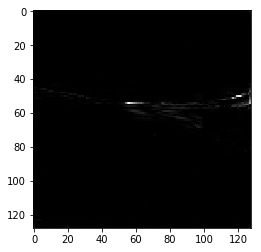

6.271189441496966


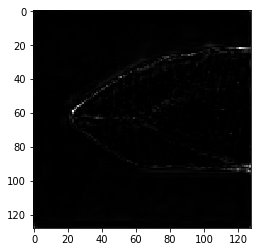

6.028570612866967


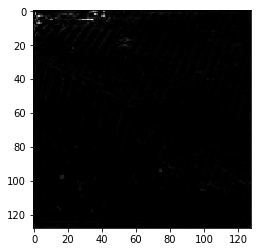

6.133952769880326


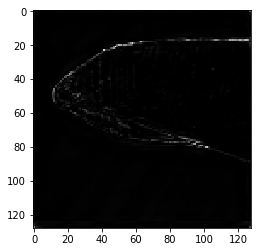

6.21495584990181


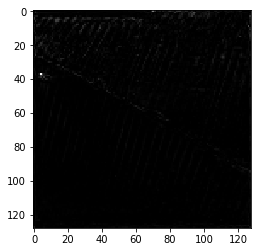

18.13451174778627


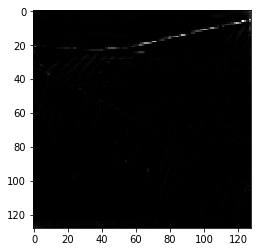

8.334300736830203


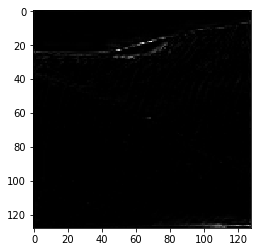

3.4320113891493573


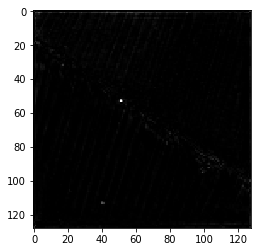

12.767317364967184


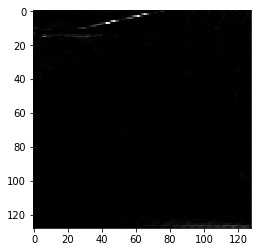

7.584705586585264


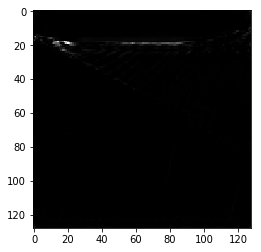

11.418523148369605


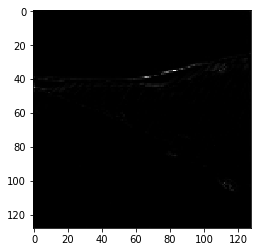

6.246982695541099


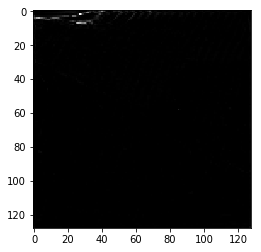

6.466700158441178


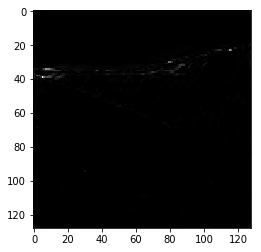

5.866622099610768


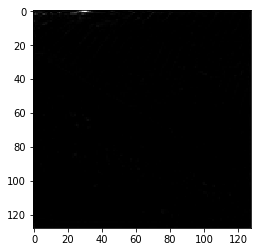

7.188433222181716


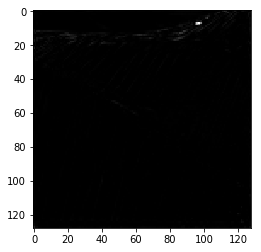

8.84021075338601


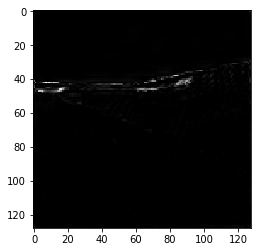

9.778671931030336


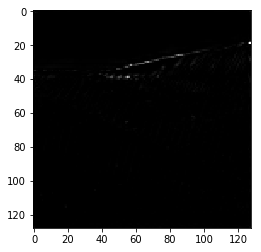

7.40511906899019


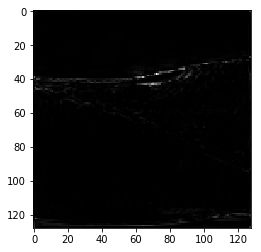

9.889384658100322


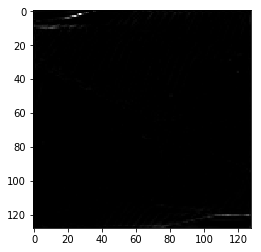

7.891782954315984


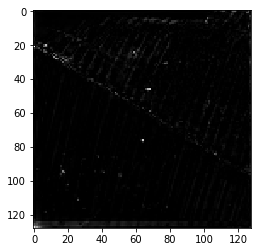

3.612704645963512


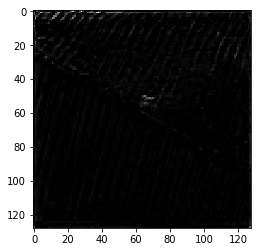

13.718541470631132


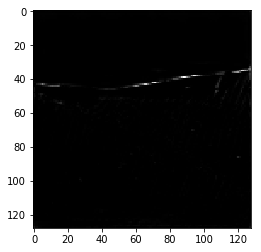

28.680363857671704


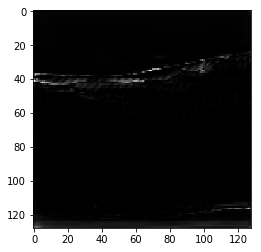

3.8993709995616954


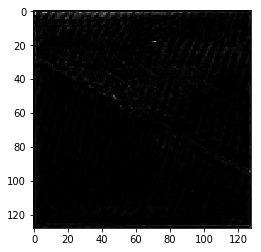

7.495781936144078


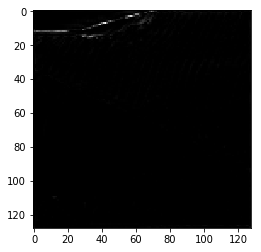

7.6616385741792925


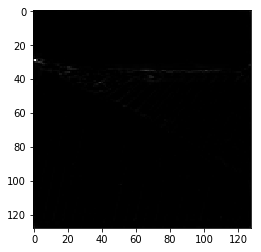

15.10462449875782


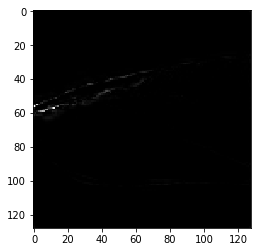

9.724554654755975


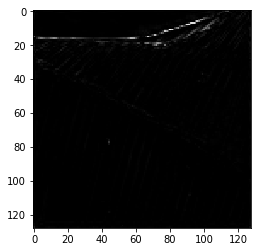

15.801418049323397


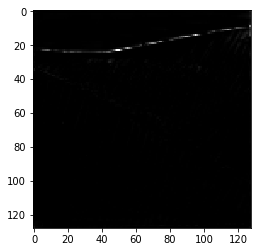

8.14557765170764


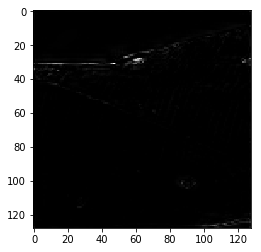

4.33758071559432


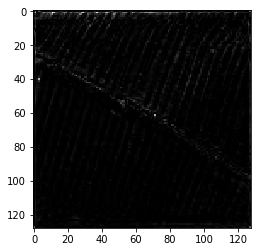

28.228103497502914


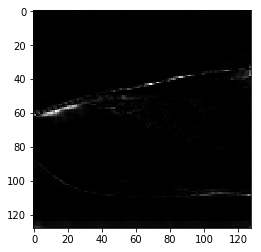

6.60979314515273


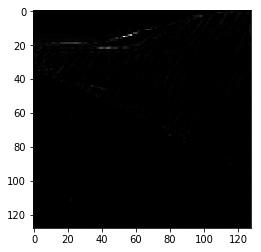

3.9991985368807867


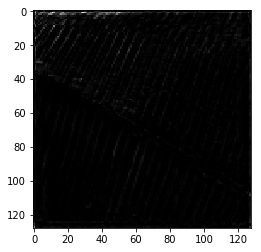

14.94530284715385


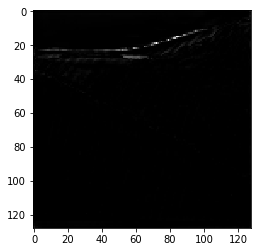

18.314060182442734


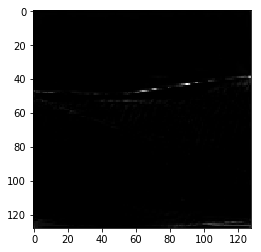

6.830117451593394


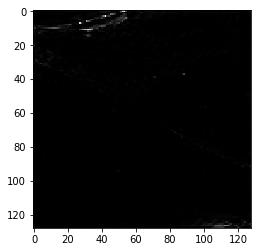

5.576231204277948


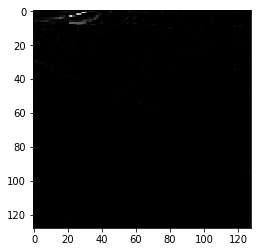

3.103909694158144


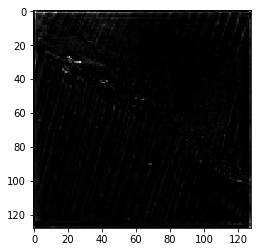

10.806051549225947


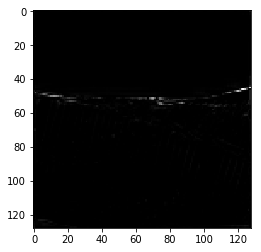

6.871472486084932


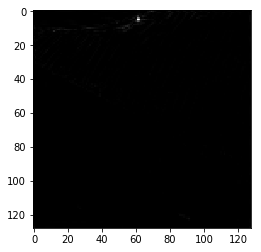

3.8321493539389726


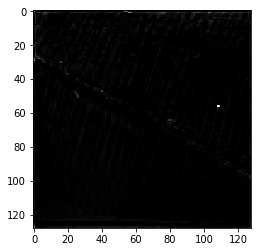

5.473907699653001


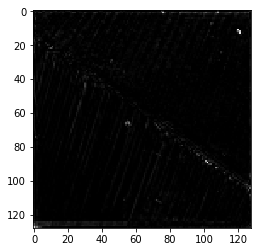

4.34283348771276


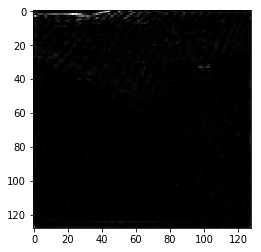

15.876351127403993


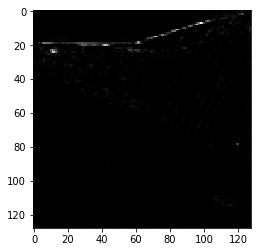

5.874427214565077


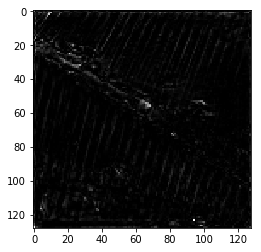

7.079872377919558


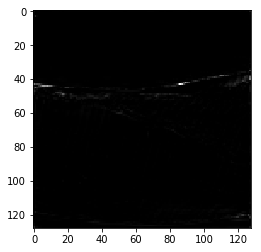

10.88350450392052


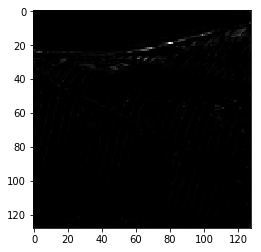

6.094022947406515


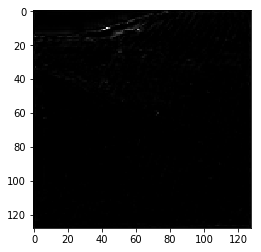

10.489141899043755


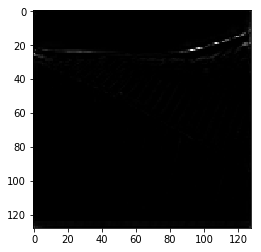

7.983001379534236


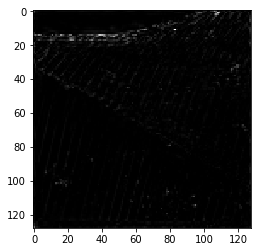

4.199822458927816


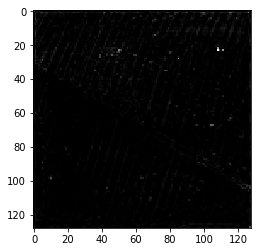

8.245639659669695


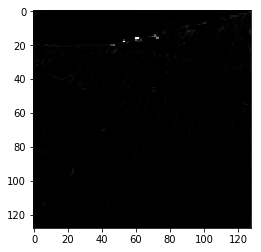

26.01512395680337


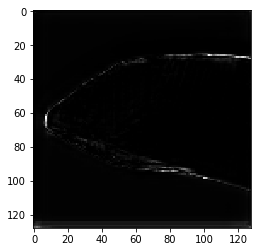

6.336291441475035


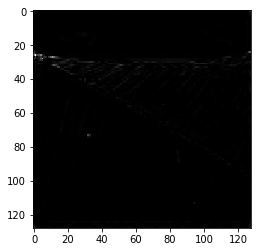

7.715447151178761


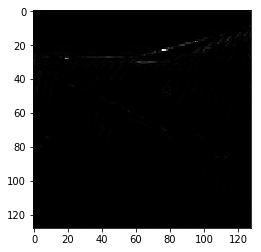

12.339206510523912


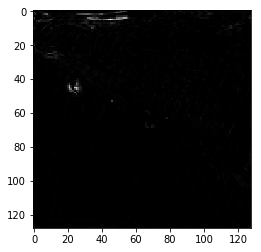

4.6083215030982165


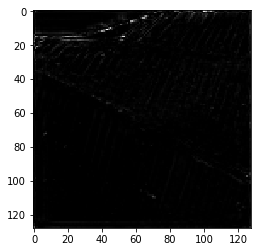

6.33458946560779


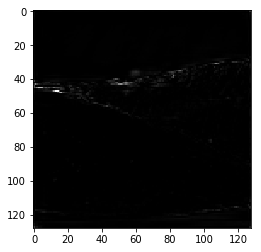

6.590934313205824


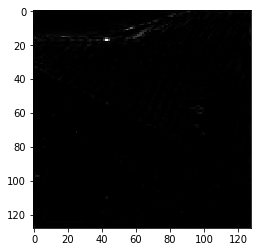

10.161539305655413


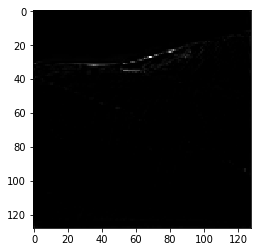

9.881058181103635


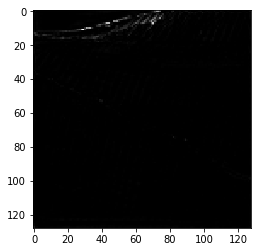

12.280426494312984


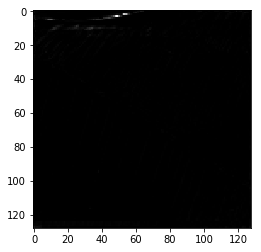

16.647858737822244


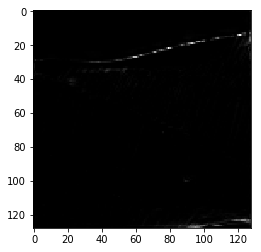

17.818531946402025


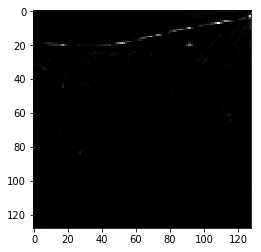

4.79284760485992


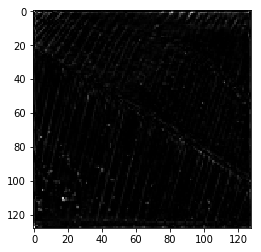

2.821655305179803


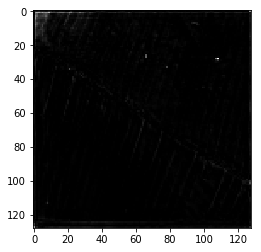

6.048803348756743


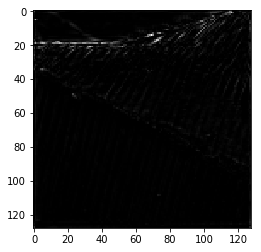

3.4636970514854903


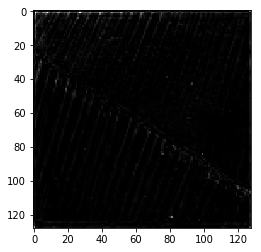

13.70952551490168


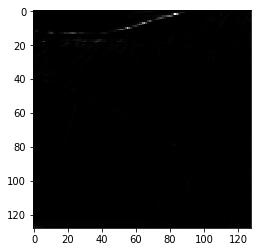

13.079842852089394


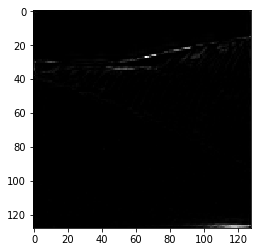

6.857883640748822


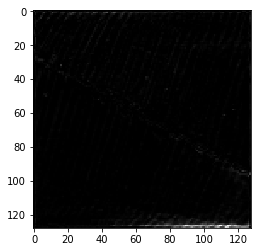

In [575]:
for i in range(imagesTest.shape[0]):
    #print(sum(sum((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2))))
    plt.imshow((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2), cmap='gray') 
    print(sum(sum((np.array(pred[i, ..., 0]-imagesTest[i,...,0])**2))))
    plt.show()